# Notes

Now it's time to do the exact same thing using a modern deep neural network library, like `PyTorch`. Micrograd is roughly modeled to this. 

So, we'll be doing the exact same thing but using the `PyTorch` API - a production grade package.

# Imports

In [1]:
import torch
import random
from value import Value
from graph_visualization_code import draw_dot

# PyTorch Node

In [2]:
x1 = torch.Tensor([2.0]).double()  ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()  ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()  ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1 * w1 + x2 * w2 + b

o = torch.tanh(n)

print(o.data.item())
o.backward()

print("----")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Micrograd is a scalar value engine. PyTorch is based on tensors (which are n-dimensional arrays of scalars). In our case, we are using just a scalar valued tensor (a tensor with only one element in it). Our scalar is cast to double (by default the values are float 32, so this gives us float 64 types).

`o` is a tensor object. Like Micrograd, PyTorch's tensor objects have `grad` and `data` attributes. The only difference here is that we need to call `.item()`, in order to grab the element from a position in the tensor (we are grabbing the specific element and stripping out the tensor).

Note by default PyTorch sets the `requires_grad` prop to `False` for efficiency reasons. You typically don't want gradients for leaf nodes (like inputs in the network).

PyTorch can do the same as Micrograd whent the tensors are single valued elements.

The big deal with PyTorch is that everything is significantly more efficient, because we are working with tensors. We can do a lot of operations in parallel with these tensors.

## Tensor Objects

Normally, you would use more complicated tensors like the following 2-by-3 array of scalars:

In [3]:
torch.Tensor([[1, 2, 3], [4, 5, 6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [4]:
torch.Tensor([[1, 2, 3], [4, 5, 6]]).shape

torch.Size([2, 3])

This is usually what you would work with in the actual libraries.

What our output tensor looks like:

In [5]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [6]:
o.item() # which is the same here as o.data.item()

0.7071066904050358

In [7]:
print(x2.grad)
print(x2.grad.item())

tensor([0.5000], dtype=torch.float64)
0.5000001283844369


# Building Neural Nets

Now that we have the mathematical machinery, we can build out neural nets. Neural nets are just a specific class of mathematical expression.

## A Single Neuron

Let's create a neuron that subscribes to the PyTorch API. 

In [8]:
class Neuron:
    def __init__(self, nin):
        """
        nin: number of inputs
        """
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)] # random weight b/w -1 and 1 for every input
        self.b = Value(random.uniform(-1, 1)) # the bias, which controls the overall trigger happiness of the neuron

    def __call__(self, x):
        """
        What we want to do here is the weighted sum, including the bias: w * x + b

        In other words, the dot product of w and x to get the forward pass of the neuron

        What we need to do here:
            1. Multiply all the elements of w, with all of the elements of x, pairwise
            2. Add the bias to the weighted sum
        """
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

In [9]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.5445354980750271)

Now we can forward a single neuron!

## Defining a Layer

Here we will define a layer of neurons. Each layer has a number of neurons. They are not connected to each other. All of the neurons are fully connected to the "input". A layer of neurons is a set of nodes evaluated independently.

In [10]:
class Layer:
    """
    A list of neurons

    nin: number of inputs for the neuron in the layer
    nout: how many neurons we will have in a layer
    """
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # to return just the final output value, instead of it being wrapped in a list

In [11]:
x = [2.0, 3.0]
n = Layer(2, 3) # a layer of three neurons, with each having two inputs
n(x)

[Value(data=0.6376467292698735),
 Value(data=-0.9925844865568738),
 Value(data=0.9061718323514683)]

Let's complete the picture and define a complete MLP. An MLP, the layers feed into each other sequentially. We take the number of inputs (nins) and list of nouts (sizes of all the layers in the MLP).

In [12]:
class MLP:

    def __init__(self, nin, nouts):
        """
        nin: number of inputs (as before)
        nouts: number of outputs (which is the neurons in a single layer) is now a list - this list defines the sizes of all the layers in the MLP
        """
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [13]:
x = [2.0, 3.0, -1.0]   # three inputs into the MLP
n = MLP(3, [4, 4, 1])  # 3 layers of size 4, 4, and 1 - the last being the output
n(x)

Value(data=0.5580788196687781)

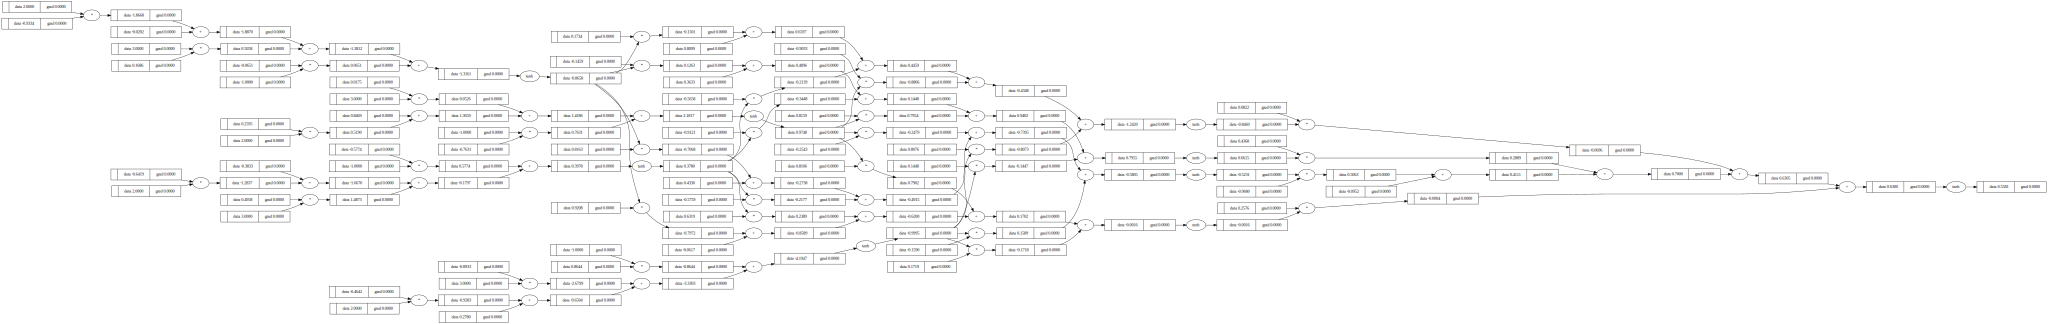

In [14]:
draw_dot(n(x))

### Going Over an MLP Example

Maybe let's back up one second to make sure we understand what's going on.

Let's start with the neuron class. A neuron takes in `nin`, which is the number of inputs. When a neuron is created we create a randomly initialized weight for each input and on randomly initialized bias value. We define the call function, which takes in `x`, the list data points. This call function then calculates the raw activation (`w*x + b`), and then passes it through our squishification function `tanh`, returning the activation of the neuron as a Value object.

So, concretely `node = Neuron(2)` will initialize a neuron with two random weights (one for each of the number of inputs) and a random bias value. Then, the following will pass the inputs to the neuron:
```
inputs = [2, 3]
node(inputs) # this yields the Value object with a data value equivalent to the activation of the neuron
```

Now, a layer is a list of neurons that are independent from each other. Our layer class takes in `nin` (the number of inputs for the neuron in the layer) and `nout` (how many neurons for that layer). A layer intializes each neuron and stores the neurons as a list of neurons. During the call of the layer, the input list is passed to each neuron in the stored `self.neurons`, and then the list of neuron Value objects is returned.

Again, concretely `layer = Layer(2, 3)` will create a layer with three neurons, each accepting two inputs. Then the following will pass the inputs to each neuron in the layer:
```
inputs = [2, 3]
layer(inputs) # this yields the list of neurons, with each taking the inputs 2 and 3
```

For the final piece of the puzzle, the MLP will also take in `nin` and `nouts` to intialize our layers and (through the intialization of layers) the neurons in each layer. So, `mlp = MLP(3, [4, 4, 1])` will create a MLP that accepts 3 input values, This is then combined with `nouts` to form the layer sizes. In this case, we'd have `[3, 4, 4, 1]` - an input layer with 3 neurons, two hidden layers with 4 neurons, and an output layer of only one neuron. Then each layer is initalized as such from the layer size array:
```
Layer(3, 4) # a layer with 4 neurons, each accepting 3 inputs
Layer(4, 4) # a layer with 4 neurons, each accepting 4 inputs
Layer(4, 1) # a layer with 1 neuron, accpeting 4 inputs
```

All of these layers are saved in `self.layers`. Then, when the MLP is called via:
```
inputs = [2, 3, -1]
mlp(inputs)
```
The three inputs will be passed into the first hidden layer, which will yield a list of 4 Value objects. This list will serve as the input for the second hidden layer, which will yield a list of 4 value objects. This list will serve as the input for the final layer, which will output a list of 1 Value object, our output.

## Adding Backprop

In [15]:
n = MLP(3, [4, 4, 1])  # 3 layers of size 4, 4, and 1 - the last being the output

Below we have four different sets of inputs in `xs`, each corresponding to a desired target value in `ys`:

In [16]:
xs = [
    [2.0, 3.0, -1.0], # so desired output is 1.0
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

This is a very simple binary classifer neural net that we would like to build.

Let's see how the current neural net is doing:

In [17]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.8539009750849189),
 Value(data=-0.07678708443341613),
 Value(data=0.25278222429325437),
 Value(data=-0.8217173004280177)]

These are the outputs of the neural net on those four examples. We want to push the first value closer to 1.0, the second closer to -1.0, and so on...

How do we accomplish this? How do we tune the weights to better predict the desired targets? 

The trick used in deep learning to achieve this is to caluculate a single number that measures the total performance of the neural net. This is called the **loss** of the neural network. We currently have the intuitive sense that we are not performing very well, so the loss will be high, and we'll want to minimize the loss.

In this particular case, what we are going to do is implement a mean squared error loss. This will iterate through the pair of our predictions and their associated ground truth and for each pair, we will take the difference, and then square them.

In [18]:
loss = sum([(y_output - y_ground_truth)**2 for y_ground_truth, y_output in zip(ys, ypred)])
loss

Value(data=9.177388137073663)

For each one of the four, we are taking the prediction and the ground truth, finding their difference, and then squaring that. Predictions closer to the ground truth will have a loss closer to 0. Squaring it, regardless if we are more negative or positive, will ensure that we will always have a positive number. Absolute value could also work.

You only get 0 when `y_ground_truth == y_output`. Otherwise, the loss for that pair will be a non-zero number. The larger the difference between the two values, the greater the loss will be. We don't want high loss, we want low loss!

The final loss of the network will be the sum of each individual loss.

Now, we want to minimize the loss, because if loss is low, then each prediction is close to its target value.

In [19]:
loss.backward()

In [20]:
n.layers[0].neurons[0].w[0].grad

6.84228812341217

We can see the influence of this neuron, in this particular layer, on the loss. Going in the direction of the gradient will affect the loss in that direction. We have this information for every neuron in the network.

It is also worth taking a look at the visualization of the loss:

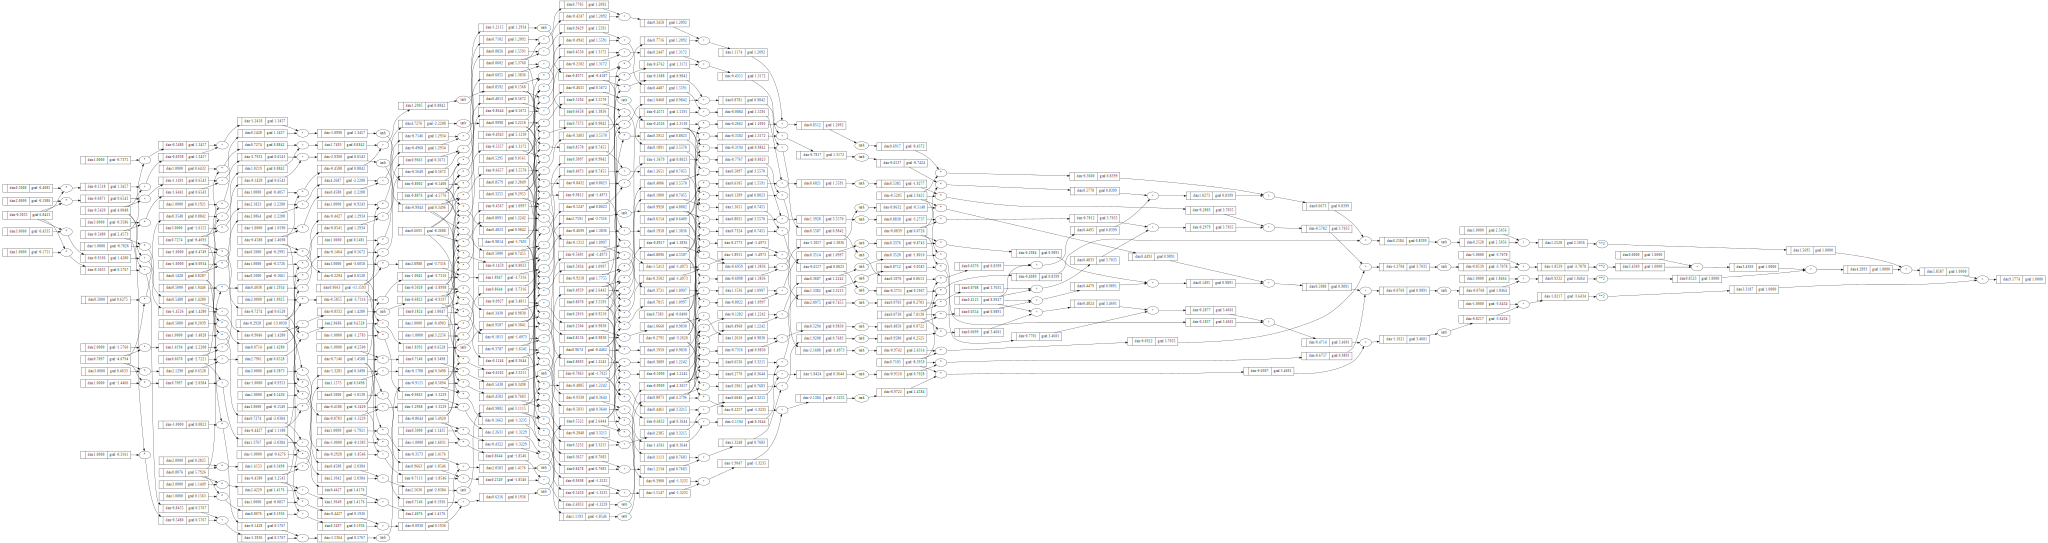

In [21]:
draw_dot(loss)

This graph has four forward passes of the neural network (one for each of the forward passes), and then it has the loss on top. This loss then backprops through each of the four forward passes, all the way through every intermediate value, all the way back to the inputs (weights and xs).

The gradients on the input data is not very useful - we can't change the input data! Input data is fixed, it is a given to a problem. However, we can use the gradients of the neural network parameters, in particular the weights and biases.

## Updating MLP to Adjust Loss

We will now want some convenience code to grab all of the parameters of the neural net, so that we can operate on all of them. For each parameter, we will nudge it a tiny amount based on the gradient information:

In [22]:
class Neuron:
    def __init__(self, nin):
        """
        nin: number of inputs
        """
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)] # random weight b/w -1 and 1 for every input
        self.b = Value(random.uniform(-1, 1)) # the bias, which controls the overall trigger happiness of the neuron

    def __call__(self, x):
        """
        What we want to do here is the weighted sum, including the bias: w * x + b

        In other words, the dot product of w and x to get the forward pass of the neuron

        What we need to do here:
            1. Multiply all the elements of w, with all of the elements of x, pairwise
            2. Add the bias to the weighted sum
        """
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        """
        PyTorch has a parameters call on every single module
        """
        return self.w + [self.b] # returns concatenation of the weights and biases

class Layer:
    """
    A list of neurons

    nin: number of inputs for the neuron in the layer
    nout: how many neurons we will have in a layer
    """
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # to return just the final output value, instead of it being wrapped in a list

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
class MLP:

    def __init__(self, nin, nouts):
        """
        nin: number of inputs (as before)
        nouts: number of outputs (which is the neurons in a single layer) is now a list - this list defines the sizes of all the layers in the MLP
        """
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [23]:
x = [2.0, 3.0, -1.0]   # three inputs into the MLP
n = MLP(3, [4, 4, 1])  # 3 layers of size 4, 4, and 1 - the last being the output
n(x)

Value(data=0.2666859027703317)

In [24]:
n.parameters()

[Value(data=0.6601914833711211),
 Value(data=-0.7497005892413311),
 Value(data=-0.2823237962366829),
 Value(data=0.5890614205483939),
 Value(data=-0.714754274104122),
 Value(data=0.7893159488402415),
 Value(data=-0.7830187637001131),
 Value(data=-0.661251621072575),
 Value(data=-0.8636857376493166),
 Value(data=0.1666492069594514),
 Value(data=0.27275553046241874),
 Value(data=-0.6536226462669741),
 Value(data=-0.9121049485805579),
 Value(data=-0.3079875814362536),
 Value(data=0.9995771462872558),
 Value(data=0.1863371776927356),
 Value(data=0.5359560389121099),
 Value(data=-0.31239338819363915),
 Value(data=0.0663334305866834),
 Value(data=-0.44498886909223434),
 Value(data=-0.6867120456101374),
 Value(data=-0.8055430605540828),
 Value(data=-0.8775403274772102),
 Value(data=0.8140200329937541),
 Value(data=-0.49906102630401317),
 Value(data=0.7419571028439331),
 Value(data=-0.29309351281384766),
 Value(data=-0.16292854633385634),
 Value(data=0.4874756742482147),
 Value(data=-0.6101786

These are all the weights and biases inside the entire neural net

In [25]:
len(n.parameters())

41

In total, this MLP has 41 parameters. 

In [26]:
xs = [
    [2.0, 3.0, -1.0], # so desired output is 1.0
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.2666859027703317),
 Value(data=0.9195974775398781),
 Value(data=0.8094018533634176),
 Value(data=0.6256724404954197)]

In [27]:
loss = sum([(y_output - y_ground_truth)**2 for y_ground_truth, y_output in zip(ys, ypred)])
loss

Value(data=7.636660229732851)

In [28]:
loss.backward()

Now, what we want to do is iterate for through every parameter in the MLP. We want to change each parameter according to the gradient information. This will be a tiny update in this gradient descent scheme.

In gradient descent, we are thinking of the gradient as a vector pointing in the direction of increased loss. Recall to our backprop examples, going in the direction of the gradient increases the final value, and we want to decrease loss, so we need to go in the direction of the negative gradient. Recall: gradient tells us the direction and rate of fastest increase, so again we need to take the inverse direction (so negate the gradient) to decrease loss.

So, we will modify each parameter by a small step size in the direction of the negative gradient.

Here is the loop:

In [29]:
for p in n.parameters():
    p.data += -0.01 * p.grad

Now that we've changed all of these parameters, the loss should have decreased a bit. Let's re-evaluate the loss:

In [30]:
ypred = [n(x) for x in xs] # recalculate the forward pass
loss = sum([(y_output - y_ground_truth)**2 for y_ground_truth, y_output in zip(ys, ypred)]) # calculating the new loss
loss

Value(data=7.353378630354066)

This means that our predications are slightly closer to the targets. So, all we have to do is keep iterating in this fashion to minimize loss as much as possible.

In [31]:
ypred

[Value(data=0.4499624216561161),
 Value(data=0.9088056932322757),
 Value(data=0.818881007099529),
 Value(data=0.6854050218768329)]

If you try to go too fast (i.e. too big of a step) you may actually overstep. We don't really know the structure of the loss function, we only know about the very local dependence of this parameters of the loss, but if we step too far we may step into a part of the loss that is completely different. This can destabilize training and potentially cause your loss to blow up!

The learning rate and the tuning of it is a subtle art. If it is too low, then it will take forever to converge. However, if it's too high, the whole thing gets unstable and loss may actual explode. The just right step size is a subtle art when using vanilla gradient descent.